In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

## Get started with Qiskit Runtime

[Qiskit Runtime](https://www.ibm.com/quantum/qiskit-runtime) is the preferred way to execute circuits on IBM Quantum backends. It is provided in a separate Python package from the `qiskit` library: `qiskit-ibm-runtime`.

#### Example circuits

For this tutorial, we will use a few example circuits. The first one is a Bell circuit, which is also used to show entanglement between qubits.

In [1]:
from qiskit import QuantumCircuit

bell_circuit = QuantumCircuit(2)
bell_circuit.h(0)
bell_circuit.cx(0, 1)
bell_circuit.measure_all()

bell_circuit.draw()


┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

The circuits that we will run are gathered in the `circuits_to_run` list. The backends have always had the ability to run a list of circuits, and we will take advantage of this feature.

In [2]:
circuits_to_run = [bell_circuit]

### How to use Qiskit Runtime

Using Qiskit Runtime is quite simple. The first step is to obtain an instance of the `QiskitRuntimeService`. The next step is to find an appropriate backend. To do so, you can search the available backends associated with the account, query their status, and then select the desired backend.

#### Initialize the `QiskitRuntimeService`

To run our circuits using Qiskit Runtime, we need to initiatlize the `QiskitRuntimeService` object with a channel. There are two possible channels. For this, we will use the `ibm_quantum` channel. If no token is passed, Qiskit Runtime will search for a saved account on the file system. The account can be saved with the following Python code:

```python
    QiskitRuntimeService.save_account(channel="ibm_quantum", token="XYZ...")
```

Because the tokens are saved in a plain text file, the file should have restricted access. The alternative would be to pass the token to the initializer:

```python
    service = QiskitRuntimeService(channel="ibm_quantum", token="XYZ...")
```

The code below works once the token is saved. The token can be obtained from the [IBM Quantum Computing](https://quantum-computing.ibm.com) home page, after login.


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')


#### List the available backends

Once the service is obtained, we can print a list of the backends that are accessible (via the `ibm_quantum` channel).

The code below prints the list of the backends (name and number of qubits) and their status (online status and queue length).

Choose a backend with a short queue to minimize your wait time. Note that the result of the cell below is very dynamic. To get the most up-to-date information about the available backends and their queue lengths, refresh the cell before launching a job.

In [4]:
backends = service.backends()
for b in backends:
    if b.name[:3] == 'ibm':
        status = b.status()
        stat = 'online' if status.operational else 'offline'
        print(f'{b.name}, {b.num_qubits} qubits, {stat}, queue length: {status.pending_jobs}')
    else:
        print(b.name)

ibm_auckland, 27 qubits, online, queue length: 215
ibmq_kolkata, 27 qubits, online, queue length: 303
ibm_seattle, 433 qubits, offline, queue length: 0
ibmq_qasm_simulator, 32 qubits, online, queue length: 0
ibmq_quito, 5 qubits, online, queue length: 88
ibmq_lima, 5 qubits, online, queue length: 33
ibmq_manila, 5 qubits, online, queue length: 452
ibm_lagos, 7 qubits, online, queue length: 536
ibm_perth, 7 qubits, online, queue length: 188
ibm_sherbrooke, 127 qubits, online, queue length: 605
ibm_nazca, 127 qubits, online, queue length: 3
ibm_algiers, 27 qubits, online, queue length: 44
ibm_cusco, 127 qubits, online, queue length: 1
ibmq_guadalupe, 16 qubits, online, queue length: 183
ibm_cairo, 27 qubits, online, queue length: 426
ibm_hanoi, 27 qubits, online, queue length: 709
ibm_nairobi, 7 qubits, online, queue length: 26
ibm_brisbane, 127 qubits, online, queue length: 462
ibmq_mumbai, 27 qubits, online, queue length: 756
ibmq_belem, 5 qubits, online, queue length: 41
ibmq_jakarta,

### Run circuits on the `ibmq_qasm_simulator`

We recommend first using the `ibmq_qasm_simulator` simulator backend, which is relatively fast for circuits with up to 32 qubits. 

Then, choose a suitable backend that is online and has fewer jobs in the queue.

To run circuits on a backend with the `QiskitRuntimeService`, follow these steps:

1. Obtain the backend from the service.
2. Create a `Sampler` to run the circuits. The `session` parameter is initialized with the backend. (We will see later other ways to use a session.)
3. Run the circuits on the `Sampler`. A `Sampler` can run a list of circuits (or just a single circuit, but here we use a list).
4. Obtain the results. The `Sampler` stores the resulting data in the `quasi_dists` parameter. The `quasi_dists` is a list holding the quasi-distribution of probabilities for each circuit.
5. Obtain the probabilities as binary probabilities associated with each state of the circuit. The states are labeled using the bit string associated with the state (otherwise the probabilties are labeled using decimal integers associated with the bit strings).

In [5]:
backend_simulator = service.get_backend(name='ibmq_qasm_simulator')

from qiskit_ibm_runtime import Sampler

sampler = Sampler(session=backend_simulator)
simulator_job = sampler.run(circuits=circuits_to_run)

simulator_result = simulator_job.result()
simulator_probabilities = [q.binary_probabilities() for q in simulator_result.quasi_dists]


The backend simulator is fast compared to other backends. However, running circuits can take from 15 seconds to a few minutes.

#### Visualize the data

Quasi-distributions can be visualized easily using the `plot_histogram` function from the `qiskit.visualization` package.

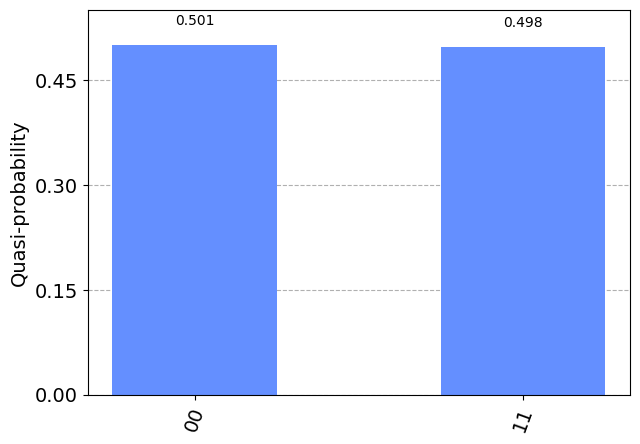

In [6]:
from qiskit.visualization import plot_histogram

plot_histogram(simulator_probabilities)

### Run circuits on a hardware backend

Now we can run the same circuits on a hardware backend. In the example below, we chose `ibm_cusco`, since it had the shortest queue. You can also run the code provided earlier to obtain a list of available backends and select from that list.

Even when there is a short queue, running circuits on a hardware backend requires more time than running them on the `ibmq_qasm_simulator`. Therefore, it is best to split the actions we want to perform into multiple steps:

1. Launch the job of running the circuits.
2. Query for the status of the job, until the job is ``DONE`` (or in ``ERROR``). You may have to wait a bit between the queries, as running circuits on hardware can take minutes (or longer).
3. Obtain the results of the hub once the job is finished.

#### Launch the job

For this example, we chose `ibm_cusco` as our backend because it had a short queue. We then initialized the `Sampler` with this backend and launched the circuits as a job. 

`Sampler.run()` is a non-blocking method for obtaining the quasi-distribution of the circuit output. It sends the circuits to the backend and returns a job object that contains all the data needed to keep track of the job. 

Here we print the `job_id`. This is essential for recovering data from executed jobs (even after a long time after the job was launched).

In [7]:
backend_hardware = service.backend("ibm_cusco")

sampler = Sampler(session=backend_hardware)
hardware_job = sampler.run(circuits=circuits_to_run)

hardware_job_id = hardware_job.job_id()
hardware_job_id

'cit61mls8tuuanrv43hg'

#### Query the job status

The status of the job may need to be called repeatedly before obtaining the results. Invoking the `results()` method on a job is blocking and does not return until the job has finished. To avoid blocking, the results should be obtained only after the job finishes.

A job can be in multiple states. After submission, the job is `QUEUED`.

In [8]:
hardware_job.status()

<JobStatus.QUEUED: 'job is queued'>

You will often see the above status when you query the job status. 

After a while, you will see the status `RUNNING`, which means that the job is actively running.

In [9]:
hardware_job.status()

<JobStatus.RUNNING: 'job is actively running'>

Finally, you will see the status `DONE`. It may also be possible that you receive an `ERROR` status, in which case you can get an error message with `hardware_job.error_message()`.

In [10]:
hardware_job.status()

<JobStatus.DONE: 'job has successfully run'>

#### Return the job metrics

It is useful to view metrics about your job. These can be ontained using the `metrics()` method, as below.

In [11]:
hardware_job.metrics()

/var/folders/m1/sk5cy0tx4m5gdnktq3rs_dm80000gn/T/ipykernel_4315/2384527364.py:1: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.seconds' attribute instead.
  hardware_job.metrics()


{'timestamps': {'created': '2023-07-21T10:41:30.613971Z',
  'finished': None,
  'running': '2023-07-21T10:41:32.263Z'},
 'bss': {'seconds': 0},
 'usage': {'quantum_seconds': 0, 'seconds': 0},
 'qiskit_version': 'qiskit_ibm_runtime-0.11.2,qiskit_terra-0.24.2,qiskit_aer-0.12.2*',
 'estimated_start_time': '2023-07-21T10:41:31.083Z',
 'estimated_completion_time': '2023-07-21T10:41:31.083Z',
 'caller': 'qiskit_ibm_runtime~sampler.py'}

What are the metrics telling us?

- First, there are three timestamps: *created*, *running*, and *finished*. These timestamps give us the waiting time in the queue (~78 seconds) and the total running time (~72 seconds). The total running time is the time required for the job in the Qiskit Runtime environment (including waiting for execution on the quantum hardware). 

- The time spent on the quantum hardware is reported by _usage_._quantum\_seconds_.

- _Executions_ gives us the number of shots used by the backend for the circuits. Here we have 54,000, which is quite a good number. Note that even though we had only one circuit, the metrics report that the backend has actually executed 5 circuits. This is due to the extra executions needeed by the error mitigation algorithms. 

- There is also data about the number of qubits in the circuits and their depth. We sent a circuit with 2 qubits and a depth of 3 (two gates and one measurement). The data in the metrics is for the transpiled circuits, which have all the 127 qubits of the backend and a maximum depth of 7 (which seems to be transpilation of the input circuit).

#### Visualize the data

Finally, we visualize the results.

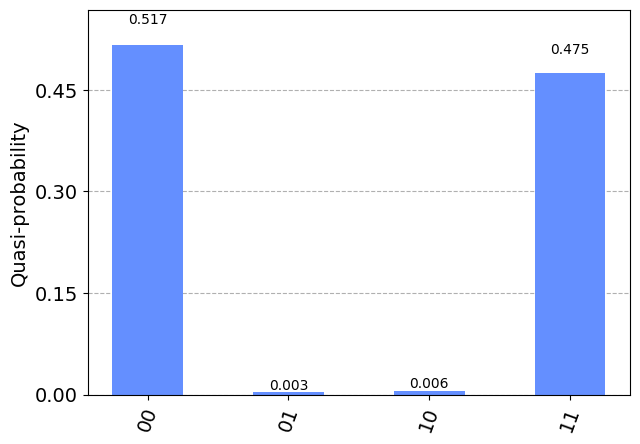

In [12]:
hardware_result = hardware_job.result()
hardware_probabilities = [q.binary_probabilities() for q in hardware_result.quasi_dists]
plot_histogram(hardware_probabilities)

In [13]:
hardware_probabilities

[{'00': 0.5165454145174758,
  '01': 0.003204420900562346,
  '10': 0.005709119187439557,
  '11': 0.4745410453945223}]

Looking at the results, they seem a bit odd. We have negative probabilities, which are the result of applying error mitigation to the `Sampler` results. However, they are very close to the ideal simulated results (taking into account the probabilistic nature of quantum computing).

### Advanced Qiskit Runtime features

In the remaining portion of this notebook, we present some advanced Qiskit Runtime features.

#### Primitives

The `Sampler` we used to run circuits and obtain the quasi-distribution is a **primitive**, a basic building block of computation using Qiskit Runtime. The other primitive is called `Estimator`, and it is more advanced in that it computes the expectation values for an operator in a given quantum state. The quantum state is the circuit. The operators are defined in `qiskit`. The `Estimator` primitive is the basic building block for hybrid algorithms such as `VQE`.

##### Estimator example

Here is an example of using the `Estimator` primitive. Note, however, that most of the time, Estimator primitives will be used inside other algorithms, rather than directly.

The most important difference between the circuits used by the `Sampler` primitive versus those used by the `Estimator` primitive is that circuits used by `Estimator` represent states; therefore, they do not contain measurements. When using the ``Estimator`` primitive, the final circuits that will be measured are composed from the state defined by the input circuit, the applied operator to the circuit, and then the inverse of the initial circuit (dagger).

The circuit used for the ``Estimator`` example is a parameterized circuit (``RealAmplitude`` from the ``qiskit.circuit.library``).

To draw the details, we first use the `decompose()` method on the circuit.

In [14]:
from qiskit.circuit.library import RealAmplitudes
ra_circuit = RealAmplitudes(num_qubits=2, reps=2)
ra_circuit.decompose().draw()

┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘

The parameters below correspond to the _theta_ angles defined in the circuit above.

In [15]:
theta = [0, 1, 1, 2, 3, 5]

For operators, we can use the `SparsePauliOp` class, which allows us to define the operators from bit strings representing Pauli operators (`I`, `X`, `Y`, `Z`).

In [16]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
observable

SparsePauliOp(['II', 'IZ', 'XI'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

The process of running `Estimator` is very similar to running `Sampler`. We have three parameters: ``circuits``, ``observables``, and ``parameter\_values``.

###### Running on `ibmq_qasm_simulator`

The `Estimator` is initialized with the ``backend\_simulator``.

In [17]:
from qiskit_ibm_runtime import Estimator

ra_estimator = Estimator(backend_simulator)
ra_job = ra_estimator.run([ra_circuit], [observable], [theta])

Then we check the status.

In [18]:
ra_job.status()

<JobStatus.RUNNING: 'job is actively running'>

The results from running the ``Estimator`` primitive are numeric values. Their meaning depends on the choice of operators. This example uses a contrived operator without very much meaning.

The results are stored as a list (actually, a NumPy array) in the job results.

In [19]:
job_result = ra_job.result()
job_result.values

array([1.5625])

The job results metadata contains information on the execution, as well as the variance of the result and the number of shots used. 

In [20]:
job_result.metadata

[{'variance': 8.95393075, 'shots': 4000}]

###### Hardware backend

This time, we are using a hardware backend. Remember to check what backend is most available (and if needed, redefine the ``backend\_hardware`` variable).

In [21]:
ra_hw_estimator = Estimator(backend_hardware)
ra_hw_job = ra_hw_estimator.run([ra_circuit], [observable], [theta])

/Users/iuliazidaru/REPO/asset-lib-code-base/venv/lib/python3.9/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:987: UserWarning: The backend ibm_cusco currently has a status of internal.
  warnings.warn(


Query the job status.

In [22]:
ra_hw_job.status()

<JobStatus.QUEUED: 'job is queued'>

When the job is `DONE`, we can get the results.

In [23]:
ra_hw_job.status()

<JobStatus.QUEUED: 'job is queued'>

You can check the usage metrics using ``ra_hw_job.metrics()``. The results we obtain are as follows:


In [25]:
ra_hw_job_results = ra_hw_job.result()
ra_hw_job_results.values

array([1.41707954])

The ideal simulation value was 1.5405. The hardware-obtained value should be slightly different because of errors. Let’s check the metadata.

In [26]:
ra_hw_job_results.metadata

[{'variance': 10.381808623576921,
  'shots': 4000,
  'readout_mitigation_num_twirled_circuits': 16,
  'readout_mitigation_shots_calibration': 8192}]

We obtained similar results. However, we have new information about the error mitigation actions taken.

##### Sessions

The session parameter in `Sampler` was encountered earlier and is a reflection of a concept used by Qiskit Runtime to group jobs together. Jobs executed in the same sessions are, as much as possible, executed one after another. The jobs wait in the queue, and then they are grouped together and executed as a batch.

When directly initializing a `Sampler` (or `Estimator`) with a backend, a session is created by Qiskit Runtime and assigned to the `Sampler` (`Estimator`). However, it is possible to create a `Session` beforehand and use it with a group of ``Sampler`` and ``Estimator`` primitives. This way, a ``Session`` can be opened using the `with` pattern from Python.

For instance, our previous example (with the ``backend\_simulator``) can be written as follows:

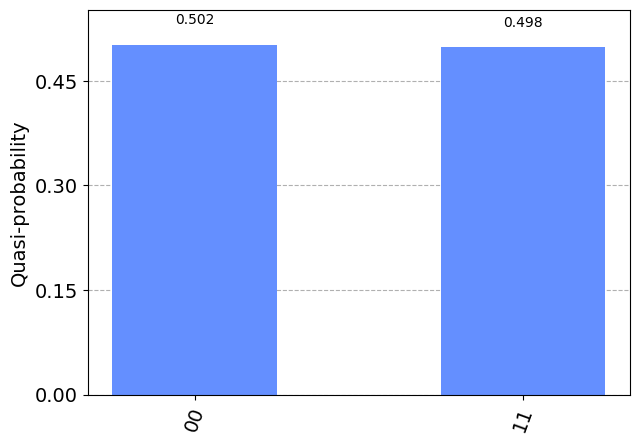

In [39]:
from qiskit_ibm_runtime import Session

session_simulator_probabilities = None

with Session(backend=backend_simulator) as session:
    session_sampler = Sampler(session=session)
    session_simulator_job = session_sampler.run(circuits=circuits_to_run)

    session_simulator_result = session_simulator_job.result()
    session_simulator_probabilities = [q.binary_probabilities() for q in session_simulator_result.quasi_dists]

plot_histogram(session_simulator_probabilities)
    

##### Options

The options are a set of parameters that can be added to the `Sampler` to influence the execution of the circuits.

The options can be used as follows:

```python
    from qiskit_ibm_runtime import Options

    options = Options()
    options.resilience_level = 1 # Minimal mitigation cost
    options.execution.shots = 2048
```

Then, add the options as parameters of the `Sampler` or `Estimator` initializers.

```python
    sampler = Sampler(session=..., options=options)
    estimator = Estimator(session=..., options=options)
```

The ``resilience\_level`` controls the level of mitigation performed. A level of **``0``** means no mitigation, and **``1``** means minimal.

There are suboptions that can apply to transpilation, resilience, execution, environment, and simulator.

In [40]:
from qiskit_ibm_runtime import Options

options = Options()
options.resilience_level = 0 # Minimal mitigation cost
options.execution.shots = 2000

options_sampler = Sampler(session=backend_hardware, options=options)
options_hw_job = options_sampler.run(circuits_to_run)

The job was successfully launched. We then query for the status.

In [41]:
options_hw_job.status()

<JobStatus.QUEUED: 'job is queued'>

Looking on the [Jobs](https://quantum-computing.ibm.com/jobs) page on IBM Quantum Platform, we see that the `ibm_cusco` backend was in the status “Online - queue paused.” If we query again:

In [42]:
options_hw_job.status()

<JobStatus.QUEUED: 'job is queued'>

We can see that we have an error.

In [43]:
options_hw_job.error_message()

The message is not very informative. Let’s check the logs to see if we can obtain further details.

In [44]:
options_hw_job.logs()

runtime_job.logs:WARNING:2023-07-21 16:00:42,037: Job logs are only available after the job finishes.


''

There are no logs available. The [Jobs](https://quantum-computing.ibm.com/jobs) page indicates that session has closed and provides no further information.

Let’s switch to another backend that we’ll call ``backend\_hardware\_2``.

In [45]:
backend_hardware_2 = service.get_backend(name='ibm_nazca')

And let’s run the options example a second time.

In [46]:
options_sampler_2 = Sampler(session=backend_hardware_2, options=options)
options_hw_job_2 = options_sampler_2.run(circuits_to_run)

In [47]:
options_hw_job_2.status()

<JobStatus.QUEUED: 'job is queued'>

In [48]:
options_hw_job_2.status()

<JobStatus.QUEUED: 'job is queued'>

Now that the job has successfully finished, let’s review the metrics.

In [49]:
options_hw_job_2.metrics()

/var/folders/m1/sk5cy0tx4m5gdnktq3rs_dm80000gn/T/ipykernel_4315/57417082.py:1: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.seconds' attribute instead.
  options_hw_job_2.metrics()


{'timestamps': {'created': '2023-07-21T13:00:43.081081Z',
  'finished': None,
  'running': None},
 'bss': {'seconds': 0},
 'usage': {'quantum_seconds': 0, 'seconds': 0},
 'qiskit_version': 'qiskit_ibm_runtime-0.11.2,qiskit_terra-0.24.2,qiskit_aer-0.12.2*',
 'estimated_start_time': '2023-07-21T13:00:43.373Z',
 'estimated_completion_time': '2023-07-21T13:00:43.373Z',
 'caller': 'qiskit_ibm_runtime~sampler.py'}

It seems that in this job, no error mitigation occurred and a single circuit was run. In addition, the number of executions was 2000, the number passed in the options.

In [50]:
options_hw_job_2.inputs

{'circuits': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x107d5e610>,),
 'parameters': [ParameterView([])],
 'circuit_indices': [0],
 'parameter_values': ((),),
 'transpilation_settings': {'skip_transpilation': False,
  'initial_layout': None,
  'layout_method': None,
  'routing_method': None,
  'approximation_degree': None,
  'optimization_settings': {'level': 3},
  'coupling_map': None,
  'basis_gates': None},
 'resilience_settings': {'noise_amplifier': 'TwoQubitAmplifier',
  'noise_factors': (1, 3, 5),
  'extrapolator': 'LinearExtrapolator',
  'level': 0},
 'run_options': {'shots': 2000,
  'init_qubits': True,
  'noise_model': None,
  'seed_simulator': None}}

Looking at the inputs, we note that the ``optimization\_level`` was kept at **``3``**, the default level, which means there was error supression. Let’s review the results.

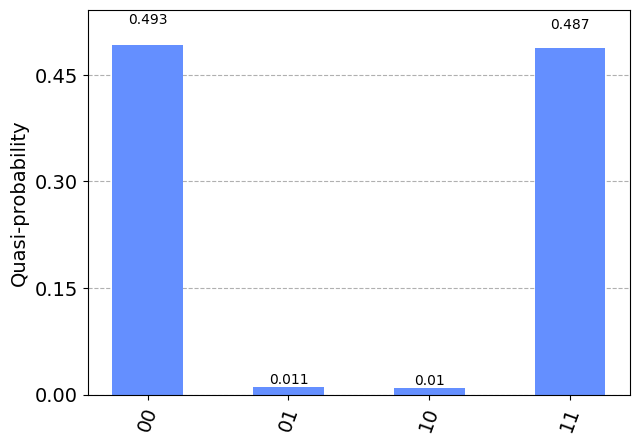

In [51]:
options_hw_job_2_result = options_hw_job_2.result()
options_hw_job_2_result_probs = [q.binary_probabilities() for q in options_hw_job_2_result.quasi_dists]
plot_histogram(options_hw_job_2_result_probs)

The results are not significantly different from the default `Sampler`, with resilience level **``1``**. However, we can see that the number of states that should not exists (`01` and `10`) is 31 from 2000, close to 1.5%. The error mitigation is improving on this number (see above).

### Additional resources

For further exploration, consult the documentation for `qiskit` and `qiskit-ibm-runtime`:

1. [Qiskit Runtime documentation](https://qiskit.org/ecosystem/ibm-runtime/)
2. [Qiskit primitives documentation](https://qiskit.org/documentation/apidoc/primitives.html)
3. [Qiskit.org](https://qiskit.org/), which features several examples on the home page
4. [Qiskit circuit library documentation](https://qiskit.org/documentation/apidoc/circuit_library.html), which lists a variety of circuits that you can use

<span style="font-size:10pt; font-weight:bold;" class = "copyright-content"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an "existing" IBM asset as part of the IBM Quantum Accelerator contract. </span>


